# Modelowanie - warsztaty, zajęcia 05

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
print("wersja seaborn'a:\n", sns.__version__)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from emosie import plot_decision

wersja seaborn'a:
 0.8.1


In [3]:
%matplotlib inline

## Powtórka
Poniżej odtwarzamy, już pokrótce, ważniejsze kroki z poprzednich zajęć:
* preprocessing danych
* podział na dane treningowe i testowe
* dopasowywanie hiperparametrów z użyciem 5-fold cross-validation na danych treningowych
* test na danych testowych

### Preprocessing
To samo co na ostatnich zajęciach, ale tym razem rach, ciach, w kilka linijek.

In [4]:
titanic = sns.load_dataset('titanic')
select_columns = ['pclass', 'age', 'sibsp', 'parch', 'fare']
dummy_columns = ['sex', 'alone', 'who']

selected = titanic.loc[:, select_columns]
dummies = pd.get_dummies(titanic, columns=dummy_columns, drop_first=True).loc[:, 'sex_male':]
titanic_preproc = pd.concat([selected, dummies], axis=1)
titanic_preproc = titanic_preproc.fillna(titanic_preproc.mean())

### Train, test split
Dzielimy dane na treningowe i testowe.  
Uzupełnij kod poniżej tak aby:
* podzielić na dane testowe i treningowe
* dane testowe stanowiły 30% oryginalnych
* wystandaryzować dane

In [5]:
y = titanic.survived.values
X_train, X_test, y_train, y_test = _______________(
    titanic_preproc.values, y, _________=___, random_state=42)

# standaryzujemy - support vector machine najlepiej działa
# na wystandaryzowanych danych
std = StandardScaler()
X_train_std = ___.fit_transform(X_train)
X_test_std = ___.fit_transform(X_test)

### Titanic z użyciem SVC
Klasyfikujemy dane z `titanic`'a z użyciem support vector classifier - **SVC**.

In [6]:
from sklearn.svm import ___

parametry = {'gamma': [0.01, 1e-3, 2e-4, 1e-4, 1e-5],
             'C': [1, 10, 100, 1000]}
print('Przeszukujemy wszystkie zestawienia hiperparametrów:', parametry)
print('Korzystamy do tego z 5-fold cross validation.')

clf = GridSearchCV(___(), parametry, cv=5)
clf.___(X_train_std, y_train)

print('Najlepsze hiperparametry SVC:', clf.best_params_)

predictions = clf._______(X_test_std)
poprawność = (predictions == y_test).mean()
print('Poprawność przewidywania naszego modelu to:', poprawność)

Przeszukujemy wszystkie zestawienia hiperparametrów: {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0002, 0.0001, 1e-05]}
Korzystamy do tego z 5-fold cross validation.
Najlepsze hiperparametry SVC: {'C': 10, 'gamma': 0.01}
Poprawność przewidywania naszego modelu to: 0.8246268656716418


## Sieci Neuronowe
Plan sekcji:
* wprowadzenie do biblioteki Keras
* najprostsza sieć neuronowa - odpowiednik regresji logistycznej
* przykłady zachowania sieci neuronowej o różnej liczbie neuronów i warstw dla prostych danych z dwoma predyktorami
* sieć neuronowa na danych titanic

Później przejdziemy do wykorzystania sieci neuronowych w analizie obrazu.

`Keras` to najprostsza biblioteka do sieci neuronowych w pythonie. Jest wysokopoziomowa, co znaczy że wiele detali wykonuje automatycznie, a nam pozwala na skupienie się na "big picture". Keras jest znane z bardzo dobrze zaprojektowanego API (interfejsu programistycznego) - co przekłada się na dużą wygodę korzystania. Dzisiaj skorzystamy ze zwykłej sekwencyjnej sieci (`Sequential`), dla której kolejne warstwy są połączone na zasadzie każdy-z-każdym (połączenie typu `Dense`).  
Zaimportujemy najpierw odpowiednie obiekty:

In [1]:
from keras.models import Sequential
from keras.layers import Dense

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Stworzymy również sztuczny dataset z użyciem funkcji `make_moons`. Chcielibyśmy utworzyć `250` punktów, z szumem na poziomie `0.25` oraz podając `random_state` jako `23` (aby przy n-tym uruchomieniu dostać podobne wyniki):

In [8]:
from sklearn.datasets import make_moons

X_moon, y_moon = make_moons(n_samples=___, noise=___, random_state=__)

Wykorzystujemy znaną już nam funkcję `plot_decision` aby wyświetlić utworzone dane:

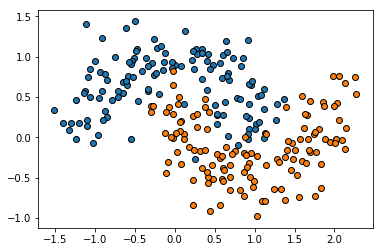

In [9]:
# wyświetlamy wygenerowane dane
plot_decision(______, ______)

Ale - tym razem sprawdzać będziemy poprawność na danych treningowych oraz testowych. W związku z tym dzielimy dane na testowe i treningowe. Niech dane testowe stanowią 25% wszystkich danych.

In [10]:
X_moon_train, X_moon_test, y_moon_train, y_moon_test = train_test_split(
    ______, ______, test_size=____, random_state=23)

Aby utworzyć sieć sekwencyjną, korzystamy najpierw z `Sequential` - w ten sposób utworzymy pustą sięc (jeszcze bez warstw) - do której będziemy "doklejać" warstwy:

In [11]:
model = Sequential()

Doklejamy najpierw warstwę "gęstą" (`Dense`) - tzn. taką której każdy neuron jest połączony z każdym w poprzedniej warstwie.  
* Pierwszy argument do `Dense` to liczba neuronów - chcemy na razie tylko jeden neuron.
* Chcemy też ustawić rodzaj aktywacji dla dodawanej warstwy, aktywacja określa jak neurony przekształcają nadchodzący sygnał. Z racji tego, że ten jeden dodawany neuron, będzie jednocześnie neuronem wyjściowym chcemy aby miał aktywację typu `'sigmoid'` (tak jak funkcja logistyczna) - tzn. minimalną wartość 0, a maksymalną 1. Aktywność tego neuronu, będzie określała czy dany punkt należy do grupy niebieskich (wartość zero), czy do pomarańczowych (wartość jeden).
* Dodawany przez nas neuron jednocześnie jest neuronem wyjściowym oraz pierwszym sąsiadującym z danymi, potrzebuje w związku z tym wiedzieć jaki jest rozmiar tych danych `input_shape`. Nasze dane mają dwa predyktory (wartości na osi x oraz wartości na osi y), w związku z czym podajemy `input_shape=(2,)` (podajemy wymiary jako *tuple* `(2,)` ponieważ dane mogłyby mieć np. wysokość i szerokość jak w przypadku zdjęć, wtedy podawalibyśmy `(wysokość, szerokość)`). 

In [12]:
model.add(Dense(_, activation=_________, input_shape=(_,)))

Aby wyświetlić podsumowanie utworzonego modelu wykorzystaj metodę `summary`:

In [13]:
model._______()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


Teraz chcemy skompilować model tzn. przygotować go do uruchomienia. Przy kompilacji podajemy funkcję kosztu (`loss`), metodę optymalizacji (`optimizer`). Możemy również poprosić aby obliczane były pewne wartości dla kolejnych kroków dopasowania modelu (`metrics`).  
* Chcemy aby funkcją kosztu była `'binary_corssentropy'` (będziemy jej zawsze używać dla problemów klasyfikacyjnych).
* Optymalizator ustawiamy na `'adam'`, to popularna metoda optymalizacji, która często prowadzi do szybszego uczenia się sieci.
* Chcemy również aby liczona była poprawność dla kolejnych kroków dopasowania sieci (`['accuracy']`)

In [14]:
model.compile(loss=_________________, optimizer=______, metrics=['accuracy'])

Czas dopasować model do danych, korzystamy do tego ze znajomej metody `.fit` - podajemy jej dane treningowe: predyktory i klasyfikacje. Chcemy też zdefiniować jak długo sieć ma się uczyć, najczęściej definiujemy to w tzw. epokach. Jedna epoka to wykorzystanie wszystkich obserwacji w treningu. Wybierzmy `250` epok. Dodatkowo korzystamy z argumentu `verbose` i ustawiamy go na `0` aby nie zaśmiecać ekranu komunikatami o postępach treningu (dla tak małych danych trening będzie bardzo szybki, nie potrzebujemy informacji o postępach).

In [15]:
history = model.___(__________, _________, epochs=___, verbose=0)

Po dopasowaniu ze zmiennej `history` możemy pobrać informację o poprawności dla kolejnych kroków dopasowania (kolejnych epok).

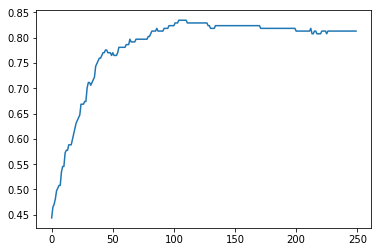

In [16]:
plt.plot(history.history['acc'])

Jeżeli masz poprawność poniżej 80%, możesz uruchomić komórkę z dopasowywaniem modelu (`model.fit(...)`) jeszcze raz.
Skorzystajmy z `plot_decision` aby wyświetlić jak dopasował się model:

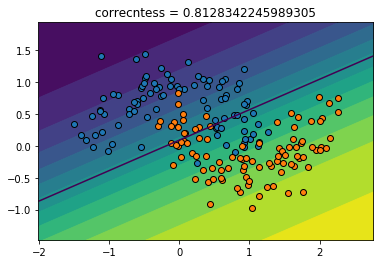

In [17]:
plot_decision(___________, ___________, clf=model)

Warto zauważyć, że rozwiązanie do którego doszła sieć jest równoznaczne z regresją logistyczną, którą już poznaliśmy.
Dzieje się tak dlatego, że nasza sieć waży predyktory (wartości na osi x i osi y w reprezentacji graficznej), sumuje i przekształca logistycznie. Dokładnie to samo robi regresja logistyczna - dobiera wagi dla predyktorów, sumuje i przekształca logistycznie. Regresja logistyczna ma jeszcze `intercept`, ale nie inaczej jest w przypadku sieci neuronowych - każdy neuron ma tzw. `bias`, który działa dokładnie tak samo jak `intercept`. W efekcie, zaimplementowaliśmy za pomocą sieci neuronowej regresję logistyczną. Potrzebujemy więcej warstw aby móc liczyć na lepsze efekty.  
Zanim jednak przejdziemy do dodawania warstw, sprawdzimy jaką poprawność otrzymujemy na danych testowych:

In [ ]:
def show_correctness(X, y, clf):
    probabilities = clf.predict(X)[:, 0]
    predictions = (probabilities > 0.5).astype('int')
    correctness = (predictions == y).mean()
    print('Poprawność wynosi: {:.2f}'.format(correctness))

In [ ]:
show_correctness(__________, __________, ______)

Czas zwiększyć poprawność modelu. Stworzymy sieć z jedną warstwą ukrytą. Model tworzymy tak samo jak wcześniej, tak samo też tworzymy warstwę wyjściową. Teraz jednak przed dodaniem warstwy wyjściowej dodajemy inną warstwę o następującej charakterysytce:
* 3 neurony
* aktywacja typu `relu`

In [19]:
model = Sequential()
model.add(Dense(_, activation=________, input_shape=(2,)))
model.add(Dense(1, activation='sigmoid'))

Kompilujemy i dopasowujemy model tak jak wcześniej:

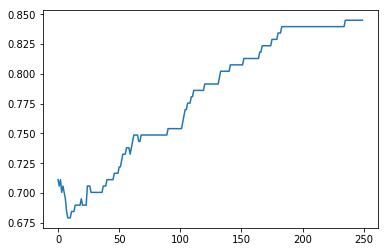

In [20]:
model.compile(loss=_________________, optimizer=_______, metrics=___________)
history = model.fit(_____________, ____________, epochs=250, verbose=0)
plt.plot(history.history['acc'])

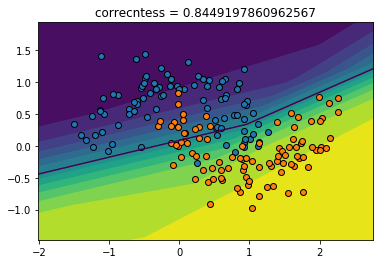

In [21]:
plot_decision(X_moon_train, y_moon_train, clf=model)

Sprawdź teraz poprawność tej sieci dla danych testowych:

### Ćwiczenie 1
Stwórz model z dwoma warstwami ukrytymi: pierwsza z 8 neuronami, druga z dwoma. Obie warstwy ukryte z aktywacją `'relu'`.

In [22]:
# tworzymy model
model = Sequential()

# warstwy ukryte
model.add(Dense(_, activation=______, input_shape=(2,)))
model.add(Dense(_, activation=______))

# warstwa wyjściowa
model.add(Dense(1, activation='sigmoid'))

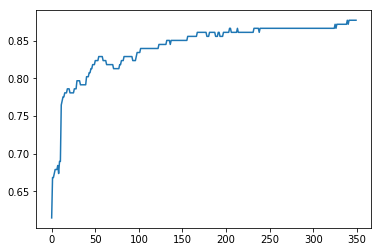

In [23]:
# kompilujemy, trenujemy i wyświetlamy poprawność
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_moon_train, y_moon_train, epochs=350, verbose=0)
plt.plot(history.history['acc'])

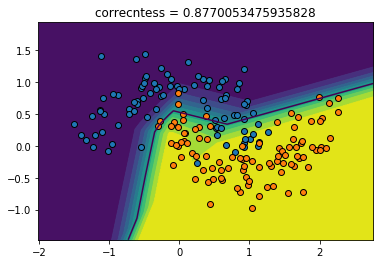

In [25]:
plot_decision(_________, __________, clf=model)

Sprawdź poprawność na danych testowych!

### Ćwiczenie 2
Zbuduj model taki sam jak w ćwiczeniu pierwszym, ale teraz druga warstwa ukryta powinna mieć 10 neuronów.

In [ ]:
# tutaj kod tworzący sieć
# model = ...
# ...

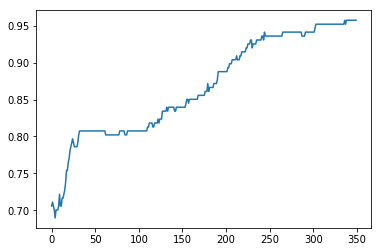

In [26]:
model.compile(loss='binary_crossentropy', optimizer=______, metrics=['accuracy'])
history = model.fit(X_moon_train, y_moon_train, epochs=350, verbose=0)
plt.plot(history.history['acc'])

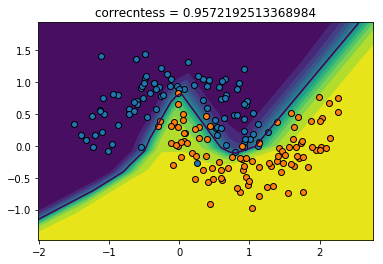

In [27]:
plot_decision(_________, __________, clf=model)

Tutaj również sprawdź poprawność na danych testowych

## Ćwiczenie 3 - wracamy do titanica
Najpierw stwórz sieć o dwóch warstwach ukrytych - każda po 10 neuronów.
Będziemy korzystać teraz z danych z tytanika, także zwróć uwagę, że mamy w nich inną liczbę predyktorów, którą musimy podać do `input_shape`:

In [28]:
X_train_std.shape

(623, 9)

In [29]:
# tworzymy model
model = Sequential()
model.add(Dense(_, activation=______, input_shape=(__,)))
model.add(Dense(_, activation=______))
model.add(Dense(1, activation='sigmoid'))

Przy trenowaniu modelu chcielibyśmy oglądać jak wraz z treningiem zmienia się poprawność dla danych testowych.
Możemy to zrobić podając dodatkowy argument `validation_data` i ustawiając go na `(X_test_std, y_test)`:

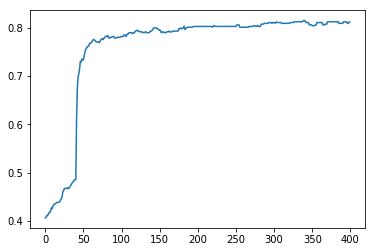

In [30]:
# trenujemy i wyświetlamy poprawność
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(________, ________, epochs=400, verbose=0,
                    validation_data=______________________________)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [34]:
print('Poprawność na danych treningowych:')
show_correctness(X_train_std, y_train, model)

print('\nPoprawność na danych testowych:')
show_correctness(X_test_std, y_test, model)

Poprawność na danych treningowych:
Poprawność wynosi: 0.86

Poprawność na danych testowych:
Poprawność wynosi: 0.81


Podobnie jak w przypadku wcześniejszych algorytmów, w przypadku sieci neuronowych też mamy do czynienia z hiperparametrami. Najbardziej oczywiste hiperparametry sieci neuronowych to: liczba warstw, liczba neuronów w każdej warstwie, rodzaje aktywacji, regularyzacja (zwykła albo dropout - ale o tym nie będziemy mówić w kontekście sieci), wreszcie: algorytm dopasowujący, learning rate (jak duże kroki w przeszukiwanej sieci są wykonywane) i inne. Nie będziemy się uczyć dopasowywania hiperparametrów dla sieci (poza wyborem liczby warstw i neuronów), ale warto pamiętać że jest taka możliwość.

# Analiza obrazu

Sieci neuronowe są bardzo często wykorzystywane do analizy obrazu albo dźwięku. Nie wykorzystuje się wtedy zwykłych sieci sekwencyjnych o połączeniach każdy z każdym:
* do analizy obrazu używa się splotowych (*konwolucyjnych*) sieci neuronowych (*convolutional neural networks*, **CNN**)
* do analizy dźwięku używa się sieci rekurencyjnych (*recurrent neural networks*, **RNN**)

Najczęściej zabawę z sieciami splotowymi i analizą obrazu zaczyna się od rozpoznawania cyfr. My jednak zrobimy coś nieco ciekawszego/zabawniejszego, pobawimy się w rozpoznawanie czy na zdjęciu jest pies czy kot.  
Potrzebne do tego dane znajdziecie tutaj: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition  
W zakładce `data` na tej stronie są do ściągnięcia dwa pliki `train.zip` oraz `test.zip`. Ściągnij tylko `train.zip`, a następnie rozpakuj do folderu, w którym znajduje się ten notebook do folderu `psy_vs_koty`, podfolderu `train`.
Ściąganie plików może trochę potrwać, więc jeżeli robisz to ćwiczenie siedząc w sali na zajęciach, szybciej będzie Ci poprosić prowadzącego o pendrive'a z danymi albo ściągnąć dane z dysku sieciowego (jeżeli masz do niego dostęp).

In [4]:
from keras.preprocessing.image import load_img, img_to_array

Wczytujemy nazwy plików graficznych:

In [5]:
import os

img_dir = r'psy_vs_koty/train'
images = os.listdir(img_dir)
images[:3]

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg']

In [6]:
full_images = [os.path.join(img_dir, img) for img in images]

Wyświetlamy zdjęcie:

Text(0.5,1,'cat.4582.jpg')

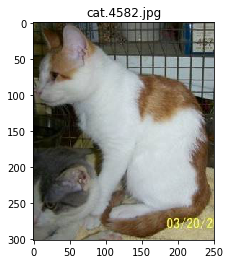

In [7]:
image_index = 6482
img = load_img(full_images[image_index])
plt.imshow(img)
plt.title(images[image_index])

Zmień kod poniżej aby wczytać inne zdjęcie. Zrób tak kilka razy aby przejrzeć różne zdjęcia. 
* Od którego indeksu `image_index` zaczynają się zdjęcia psów?
* Do datasetu, z którego korzystamy zgłaszane były problemy. Sprawdź pliki omawiane w komentarzach poniżej:
  > Image cat.7377.jpg is labelled as a cat. However it is a person. Not a dog, not a cat. Why is it in the data?
  
  oraz:
  
  > Unless there is a cat in 1 pixel of this image I can't see, image cat.4085.jpg is clearly a dog to me.

Text(0.5,1,'dog.10035.jpg')

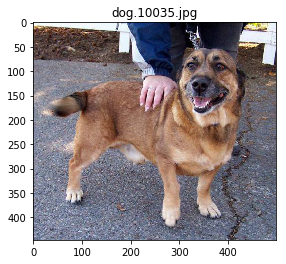

In [8]:
image_index = _____
img = load_img(full_images[image_index])
plt.imshow(img)
plt.title(images[image_index])

Zdjęcia są w różnych rozmiarach, musimy je przekształcić wszystkie na ten sam rozmiar. Ponadto aby oszczędzić czasu na treningu zredukujemy zdjęcia do rozmiaru 50 na 50 pikseli. Korzystamy z `target_size` w kodzie poniżej aby wyświetlić pomniejszony obraz (chcemy 50 na 50 pikseli):

Text(0.5,1,'dog.10121.jpg')

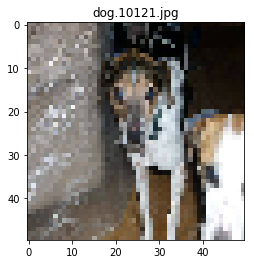

In [9]:
image_index = 12639
img = load_img(full_images[image_index], target_size=(__, __))
plt.imshow(img)
plt.title(images[image_index])

## Convolution
**Splot** to operacja, z którą już mieliście do czynienia na analizie danych eeg. Filtrowanie sygnału, czy też analiza czas częstość wykorzystuje operację splotu. Podobnie sieci neuronowe do analizy obrazu - przy czym w tym wypadku splot odbywa się w dwóch wymiarach. Oryginalny obrazek jest przekształcany za pomocą splotu - każdy pixel tworzony jest ponownie poprzez przemnożenie przez filtr (*kernel*) danego pixela i jego sąsiadów a następnie zsumowanie otrzymanych wartości:  
<img src=https://ahmedbesbes.com/images/GIF.gif>
W przypadku splotowzch sieci neuronowych (**CNN**) - neurony uczą się wag filtrów wykorzystywanych w splocie.  
Najpierw jednak kilka przykładów, celem lepszego zrozumienie splotu w 2d i jego użyteczności do analizy obrazu.

### Ćwiczenie
Poniżej wczytujemy jeden wybrany obrazek, następnie uśredniamy jego wymiar RGB aby otrzymać obraz czarno-biały, wreszcie wyświetlamy obrazek. Uzupełnij kod poniżej:

(-0.5, 284.5, 249.5, -0.5)

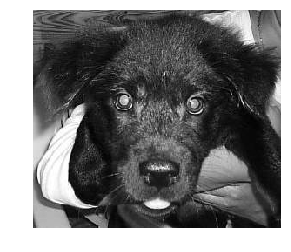

In [10]:
# wczytujemy zdjęcie
image_index = 12856
test_image = img_to_array(load_img(full_images[image_index]))

# uśredniamy wymiar RGB
test_image_gr = test_image.mean(axis=_)

# wyświetlamy
plt.imshow(test_image_gr, cmap='gray')

# aby pozbyć się indeksów pikseli na osiach:
plt.axis('off')

### Przykłady różnych splotów

(-0.5, 2.5, 2.5, -0.5)

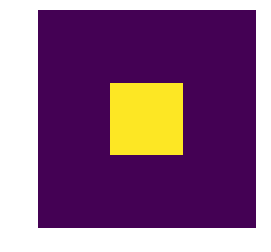

In [11]:
kernel1 = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])
plt.imshow(kernel1)
plt.axis('off')

Wczytujemy `convolve2d` ze scipy aby móc wykonać splot.

In [12]:
from scipy.signal import convolve2d

Pierwszy podajemy obrazek czarno-biały psiego pyszczka, następnie podajemy utworzony filtr (`krenel1`):

(-0.5, 286.5, 251.5, -0.5)

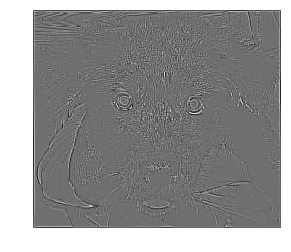

In [13]:
convolved_image1 = convolve2d(__________, _______)

plt.imshow(convolved_image1, cmap='gray')
plt.axis('off')

(-0.5, 2.5, 2.5, -0.5)

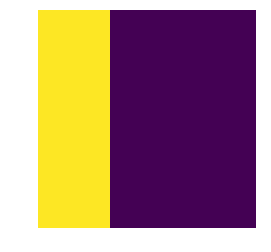

In [20]:
kernel2 = np.array([[2, -1, -1],
                    [2, -1, -1],
                    [2, -1, -1]])
plt.imshow(kernel2)
plt.axis('off')

(-0.5, 286.5, 251.5, -0.5)

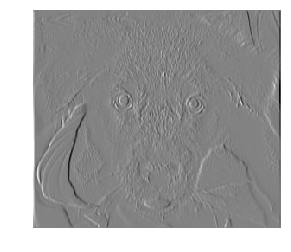

In [21]:
convolved_image2 = convolve2d(__________, kernel2)

plt.imshow(convolved_image2, cmap=_____)
plt.axis('off')

(-0.5, 3.5, 3.5, -0.5)

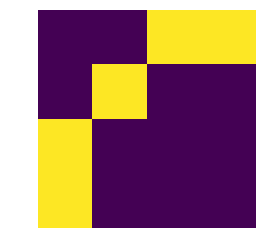

In [16]:
kernel3 = np.array([[-1, -1, 2, 2],
                   [-1, 2, -1, -1],
                   [2, -1, -1, -1],
                   [2, -1, -1, -1]])
plt.imshow(kernel3)
plt.axis('off')

(-0.5, 287.5, 252.5, -0.5)

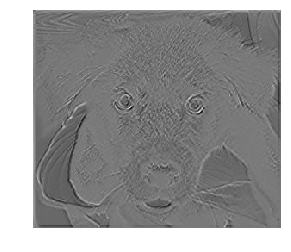

In [17]:
convolved_image3 = convolve2d(________, kernel3)

plt.imshow(_______________, cmap=______)
plt.axis('off')

Zauważ że ten ostatni filtr dosyć silnie reaguje na okolice oczu:

(-0.5, 287.5, 252.5, -0.5)

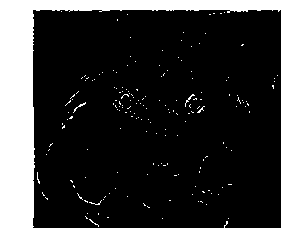

In [18]:
plt.imshow(convolved_image3 > 220, cmap='gray')
plt.axis('off')

### Zestawienie filtrów i efektów splotu 2d

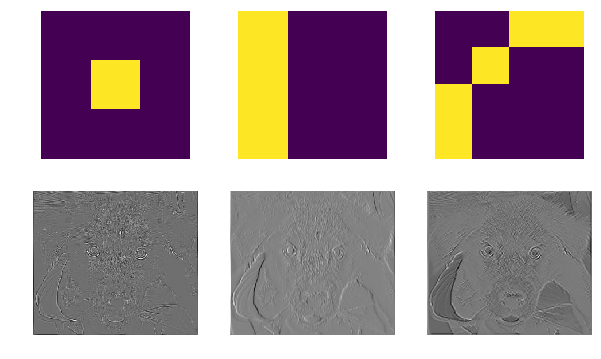

In [22]:
# zestawienie
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

ax[0, 0].imshow(kernel1)
ax[0, 1].imshow(kernel2)
ax[0, 2].imshow(kernel3)

ax[1, 0].imshow(convolved_image1, cmap='gray')
ax[1, 1].imshow(convolved_image2, cmap='gray')
ax[1, 2].imshow(convolved_image3, cmap='gray')

for a in ax.ravel():
    a.axis('off')

## Wczytujemy obrazy
Wczytujemy 10000 obrazów, po 5000 na kategorię (trening na wszystkich trwałby zbyt długo).

In [47]:
from emosie import load_images

X, y = load_images(img_dir, n_images=_____, resize=(__, __))

**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************


Po wczytaniu dzielimy zdjęcia na treningowe i testowe. Mamy aż 10 000 obrazów, więc możemy na dane testowe przeznaczyć tylko 10% (moglibyśmy przeznaczyć jeszcze mniej, nawet 2%), 10% z 10 000 to i tak 1000 zdjęć:

In [48]:
X_train, X_test, y_train, y_test = train_test_split(_, _, test_size=___, random_state=23)

Do sieci typu CNN potrzebujemy dodatkowych warstw:

In [54]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout

Dokładnie co robi model budowany poniżej opowiem Wam pod koniec zajęć albo na początku następnych. Możecie poczytać ten kod poniżej ale nie oczekuję, że będziecie rozumieć np. co to jest max pooling. Wybór warstw i ich kolejność mogłyby być inne, często trudno jest z góry przewidzieć jaka dokładnie architektura sieci będzie dobra do danego problemu.

In [55]:
model = Sequential()

# tworzymy dwie warstwy splotowe, następnie max pooling
model.add(Conv2D(16, (4, 4), input_shape=(50, 50, 3), activation='relu'))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

# tworzymy kolejne dwie warstwy splotowe, następnie max pooling
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# na koniec 'prostujemy' wszystkie filtry do jednego wektora i dodajemy 64 zwykłe neurony
model.add(Flatten())
model.add(Dense(64, activation='relu'))

# i neuron wyjściowy, który mówi pies (1) albo kot (0)
model.add(Dense(1, activation='sigmoid'))

# i kompilujemy tak jak zwykle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 47, 47, 16)        784       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 45, 45, 16)        2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 32)        4640      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 800)               0         
__________

Zauważ, że sieć ma w sumie ponad 68 tysięcy parametrów (wag połączeń) - a na współczesne standardy zbudowaliśmy dosyć małą sieć.

Trening dużej sieci na komputerze bez wspomagania GPU będzie trwał długo, z tego względu ustawimy liczbę epok tylko na `10`. Oprócz czasu oczekiwania przy tej liczbie parametrów (względem obrazków używanych w treningu) przy wielu epokach możemy łatwo przetrenować sieć doprowadzając do świetnej poprawności na danych treningowych, ale słabej na danych testowych. I tak ryzyko przetrenowania jest całkiem możliwe ponieważ nie stosujemy żadnej regularyzacji.

In [57]:
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
9000/9000 [==============================] - 56s 6ms/step - loss: 0.7965 - acc: 0.5692
Epoch 2/10
9000/9000 [==============================] - 54s 6ms/step - loss: 0.6348 - acc: 0.6388
Epoch 3/10
9000/9000 [==============================] - 54s 6ms/step - loss: 0.5940 - acc: 0.6849
Epoch 4/10
9000/9000 [==============================] - 53s 6ms/step - loss: 0.5621 - acc: 0.7081
Epoch 5/10
9000/9000 [==============================] - 54s 6ms/step - loss: 0.5443 - acc: 0.7251
Epoch 6/10
9000/9000 [==============================] - 54s 6ms/step - loss: 0.5051 - acc: 0.7559
Epoch 7/10
9000/9000 [==============================] - 54s 6ms/step - loss: 0.4765 - acc: 0.7730
Epoch 8/10
9000/9000 [==============================] - 53s 6ms/step - loss: 0.4398 - acc: 0.7953
Epoch 9/10
9000/9000 [==============================] - 54s 6ms/step - loss: 0.4044 - acc: 0.8156
Epoch 10/10
9000/9000 [==============================] - 58s 6ms/step - loss: 0.3668 - acc: 0.8351


Zauważ że juś po drugim przejściu przez dane (epoce) poprawność wynosi ponad 60% i stosunkowo szybko rośnie w kolejnych przejściach. To niestety zbyt piękne aby było prawdziwe - sugeruje że sieć zapamiętuje przykłady zamiast wyuczyć się wzorców pomagających rozpoznać psy i koty. Sprawdźmy to - zobaczmy jaką mamy poprawność na danych treningowych i testowych:

Poprawność na danych treningowych:
Poprawność wynosi: 0.86

Poprawność na danych testowych:
Poprawność wynosi: 0.74


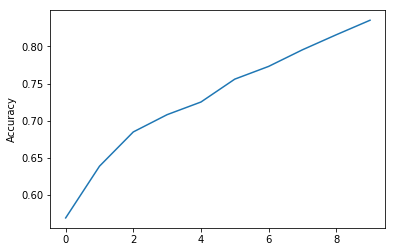

In [58]:
plt.plot(history.history['acc'])
plt.ylabel('Accuracy')

print('Poprawność na danych treningowych:')
show_correctness(X_train, y_train, model)

print('\nPoprawność na danych testowych:')
show_correctness(X_test, y_test, model)

Poprawność na danych testowych jest znacząco wyższa od 50%, więc model nauczył się czegoś, ale znacznie niższa od poprawności na danych treningowych, a więc możemy mieć do czynienia z przetrenowaniem (*overfitting*). Spróbujemy temu zapobiec dodając do sieci regularyzację.  
Zanim przejdziemy do tego kroku sprawdźmy kilka przykładów, które sieć rozpoznaje poprawnie i kilka rozpoznanych niepoprawnie.

In [59]:
# 25 pierwszych zdjęć testowych:
test_sample = X_test[:25]
predictions = model.predict(test_sample)
true_labels = y_test[:25]

(-0.5, 49.5, 49.5, -0.5)

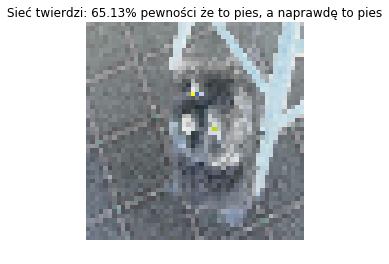

In [63]:
check_idx = 0
plt.imshow(test_sample[check_idx])
text = 'Sieć twierdzi: {:.2f}% pewności że to pies, a naprawdę to {}'
plt.title(text.format(predictions[check_idx, 0] * 100., ['kot', 'pies'][true_labels[check_idx]]))
plt.axis('off')

(-0.5, 49.5, 49.5, -0.5)

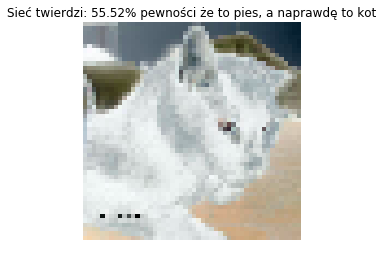

In [80]:
check_idx = 8
plt.imshow(test_sample[check_idx])
text = 'Sieć twierdzi: {:.2f}% pewności że to pies, a naprawdę to {}'
plt.title(text.format(predictions[check_idx, 0] * 100., ['kot', 'pies'][true_labels[check_idx]]))
plt.axis('off')

## Regularyzacja sieci
Budujemy całą sieć tak samo jak wcześniej, dodajemy jednak `Dropout` do jednej z ostatnich warstw.
Dropout to prosty sposób regularyzacji - z danej warstwy losowo co pewien czas usuwana jest część neuronów. Prowadzi to do dużo wolniejszego uczenia się, ale zapobiega sytuacji w której neurony bądź ich kombinacje zapamiętują konkretne przykłady treningowe. 
`Dropout(0.25)` prowadzi do wyrzucenia 25% neuronów przy każdym etapie treningowym. W naszym wypadku chcemy odrzucać 50% neuronów przy treningu.

### Ćwiczenie
Uzupełnij brakującą linijkę aby dodać dropout. Pamiętaj że dodajemy element do sieci za pomocą `model.add()`.

In [49]:
model = Sequential()

# tworzymy dwie warstwy splotowe, następnie max pooling
model.add(Conv2D(16, (4, 4), input_shape=(50, 50, 3), activation='relu'))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

# tworzymy kolejne dwie warstwy splotowe, następnie max pooling
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# na koniec 'prostujemy' wszystkie filtry do jednego wektora i dodajemy 64 zwykłe neurony
model.add(Flatten())
model.add(Dense(64, activation='relu'))

# ! TUTAJ ĆWICZENIE, BRAKUJĄCA LINIJKA !
# model.___(______(____))
model.add(Dropout(0.5))

# i neuron wyjściowy, który mówi pies (1) albo kot (0)
# zwróć uwagę, że zamiast activ
model.add(Dense(1, activation='sigmoid'))

# i kompilujemy tak jak zwykle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Regularyzacja prowadzi do dużo wolniejszego uczenia się, dlatego tym razem będziemy trenować przez więcej epok - co najmniej 20.
To trochę potrwa, także cierpliwości...

In [ ]:
history = model.fit(X_train, y_train, epochs=__, validation_data=(X_test, y_test))

In [ ]:
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='testing')
plt.ylabel('Accuracy')
plt.legend()

In [52]:
print('Poprawność na danych treningowych:')
show_correctness(X_train, y_train, model)

print('\nPoprawność na danych testowych:')
show_correctness(X_test, y_test, model)

Poprawność na danych treningowych:
Poprawność wynosi: 0.94

Poprawność na danych testowych:
Poprawność wynosi: 0.73


Korzystając z reguralyzacji dochodzimy do poprawności powyżej 70%  
(mogłeś/mogłaś mieć co prawda podobną poprawność bez regularyzacji, pierwsza wersja notebooka powstawała z użyciem tylko 3000 zdjęć - w tej sytuacji model miał poprawnośc na danych testowych w okolicach 60%).  
To cały czas nie jest model, z którego bylibyśmy zadowoleni w praktyce, ale jak na zabawę na słabym komputerze jest ok. Do wyższe poprawności potrzebowalibyśmy więcej danych - tzn. wczytania wszystkich 25 000 zdjęć. Moglibyśmy też zredukować skalowanie (obecnie skalujemy wszystkie zdjęcia do rozmiaru 50 na 50 pikseli - w takim rozmiarze niektóre zdjęcia będą trudne do zidentyfikowania.  
Z `25 000` zdjęć można zresztą w praktyce zrobić nawet pół miliona - obracając, skalując i przycinając zdjęcia (można to robić automatycznie z wykorzystaniem `keras.preprocessing.image.ImageDataGenerator`. Taka liczba przykładów doprowadziłaby naszą sieć do dużo lepszej poprawności.  
Inną strategią jest skorzystanie z sieci wcześniej wytrenowanej na milionach zdjęć (jest sporo takich dostępnych publicznie - wliczając kilka bardzo znanych architektur) i dokleić do jej ostatnich pięter kilkaset neuronów pozwalających na klasyfikację pies vs kot. Wtedy trening odbywałby się na takiej hybrydowej sieci - duża część zastygła, wytrenowana już wcześniej, a tylko końcowa warstwa (albo warstwy) są trenowane z wykorzystaniem posiadanych danych.